<a href="https://colab.research.google.com/github/ori112/student_performance/blob/main/student_performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## importing libraries, data and EDA

In [12]:
# importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import pymc as pm
import arviz as az
from sklearn.preprocessing import StandardScaler

In [13]:
# importing csv
df = pd.read_csv(r"/content/student_performance.csv")

In [14]:
# inspecting head
df.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


In [15]:
# inspecting the df columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB


most of the varibales are distributed in a uniform way <br>
target variable is somewhat normmaly distributed

<Axes: xlabel='Performance Index', ylabel='Count'>

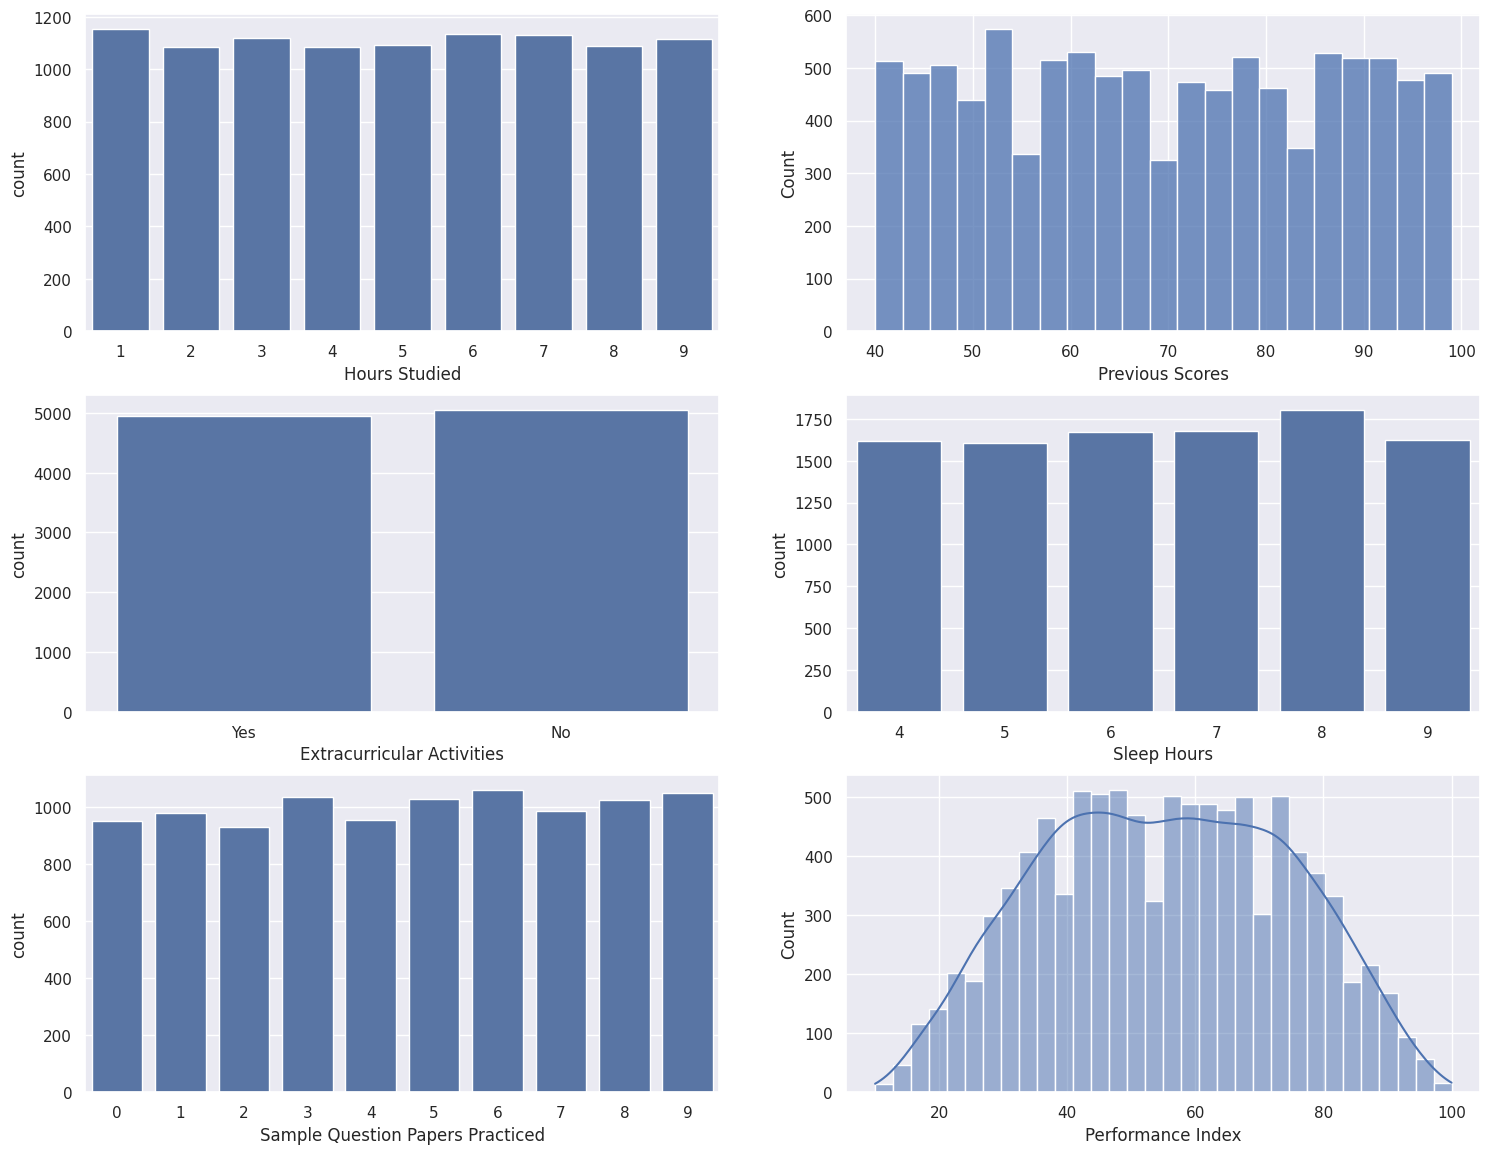

In [16]:
# inspecting distributions of features and target variable

plt.figure(figsize=(18,14))

plt.subplot(3,2,1)
sns.countplot(data=df, x="Hours Studied")
plt.subplot(3,2,2)
sns.histplot(data=df, x="Previous Scores")
plt.subplot(3,2,3)
sns.countplot(data=df, x="Extracurricular Activities")
plt.subplot(3,2,4)
sns.countplot(data=df, x="Sleep Hours")
plt.subplot(3,2,5)
sns.countplot(data=df, x="Sample Question Papers Practiced")
plt.subplot(3,2,6)
sns.histplot(data=df, x="Performance Index", kde=True)


target variable is clean from outliers

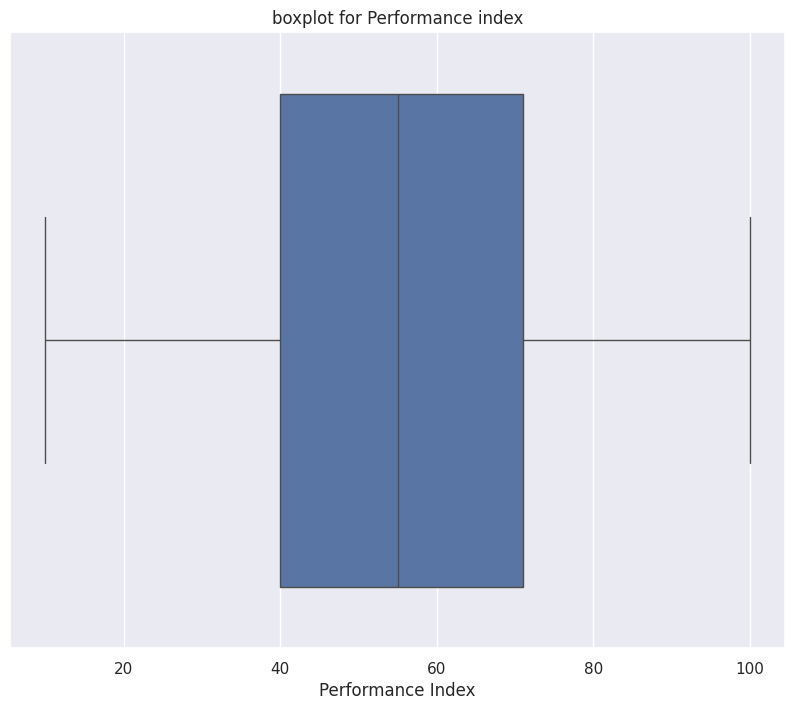

In [17]:
# inspecting for outliers in target variable
plt.figure(figsize=(10,8))
sns.boxplot(data=df, x="Performance Index")
plt.title("boxplot for Performance index")
plt.show()

In [18]:
# encoding values for extra curricular column
def encode_extracurricular(df):
    df["Extracurricular Activities"] = df["Extracurricular Activities"].map({"Yes": 1, "No": 0})
    return df

In [19]:
# updating the df
df = encode_extracurricular(df)

most correlated features with targer variable are Previos Scores and Hours studied <br>
this two features are un-correlated

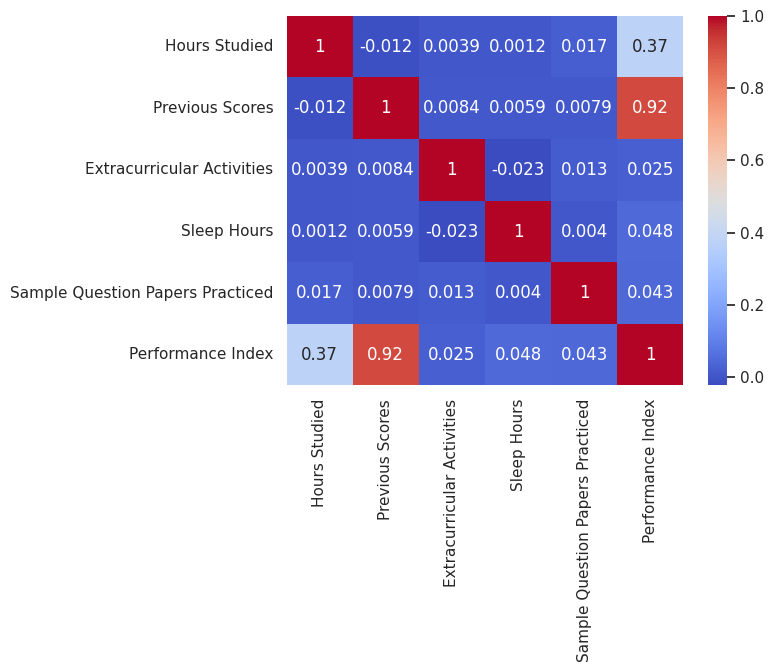

In [20]:
# inspecting correlations in df
plt.figure()
sns.heatmap(data=df.corr(), annot=True, cmap="coolwarm")
plt.show()

## model creation
### creating several models with a base model

In [10]:
# extract values
hours = df["Hours Studied"].values
previous = df["Previous Scores"].values
sleep = df["Sleep Hours"].values
practice = df["Sample Question Papers Practiced"].values
extracurricular = df["Extracurricular Activities"].values
performance = df["Performance Index"].values
interaction = hours * previous

In [22]:
with pm.Model() as base_model_noint:

    # Priors
    beta_0 = pm.Normal("beta_0", mu=0, sigma=10)
    beta_hours = pm.Normal("beta_hours", mu=0, sigma=10)
    beta_previous = pm.Normal("beta_previous", mu=0, sigma=10)

    # sigma for error term
    sigma = pm.HalfNormal("sigma", sigma=10)

    # mu linear model
    mu = beta_0 + beta_hours * hours + beta_previous * previous

    # Likelihood
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=performance)

    # Sampling
    idata = pm.sample(tune=2000, draws=2000, chains=4, target_accept=0.95, return_inferencedata=True)

    # Posterior predictive
    ppc = pm.sample_posterior_predictive(idata, return_inferencedata=True)
    idata.extend(ppc)


Output()

Output()

In [23]:
with pm.Model() as base_model_int:
    # Priors
    beta_0 = pm.Normal("beta_0", mu=0, sigma=10)
    beta_hours = pm.Normal("beta_hours", mu=0, sigma=10)
    beta_previous = pm.Normal("beta_previous", mu=0, sigma=10)
    beta_interaction = pm.Normal("beta_interaction", mu=0, sigma=10)

    # Sigma for error
    sigma = pm.HalfNormal("sigma", sigma=10)

    # Linear model with interaction term
    mu = (
        beta_0
        + beta_hours * hours
        + beta_previous * previous
        + beta_interaction * interaction
    )

    # Likelihood
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=performance)

    # Sampling
    idata_int = pm.sample(tune=2000, draws=2000, chains=4, target_accept=0.95, return_inferencedata=True)

    # Posterior predictive
    ppc_int = pm.sample_posterior_predictive(idata_int, return_inferencedata=True)
    idata_int.extend(ppc_int)

Output()

Output()

In [21]:
# scaling the df
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[["Hours Studied", "Previous Scores", "Sleep Hours", "Sample Question Papers Practiced"]] = scaler.fit_transform(
    df_scaled[["Hours Studied", "Previous Scores", "Sleep Hours", "Sample Question Papers Practiced"]]
)

# extract scaled values
hours_scaled = df_scaled["Hours Studied"].values
previous_scaled = df_scaled["Previous Scores"].values
sleep_scaled = df_scaled["Sleep Hours"].values
practice_scaled = df_scaled["Sample Question Papers Practiced"].values
extracurricular_scaled = df_scaled["Extracurricular Activities"].values
interaction_scaled = hours_scaled * previous_scaled

with pm.Model() as base_model_features:
    # Priors
    beta_0 = pm.Normal("beta_0", mu=0, sigma=10)
    beta_hours = pm.Normal("beta_hours", mu=0, sigma=10)
    beta_previous = pm.Normal("beta_previous", mu=0, sigma=10)
    beta_sleep = pm.Normal("beta_sleep", mu=0, sigma=10)
    beta_practice = pm.Normal("beta_practice", mu=0, sigma=10)
    beta_extracurricular = pm.Normal("beta_extracurricular", mu=0, sigma=10)


    # Sigma for error
    sigma = pm.HalfNormal("sigma", sigma=10)

    # Linear model with available features
    mu = (
        beta_0
        + beta_hours * hours_scaled
        + beta_previous * previous_scaled
        + beta_sleep * sleep_scaled
        + beta_practice * practice_scaled
        + beta_extracurricular * extracurricular_scaled
    )

    # Likelihood
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=performance)

    # Sampling
    idata_features = pm.sample(tune=2000, draws=2000, chains=4, target_accept=0.95, return_inferencedata=True)

    # Posterior predictive
    ppc_int = pm.sample_posterior_predictive(idata_features, return_inferencedata=True)
    idata_features.extend(ppc_int)


Output()

Output()

In [24]:
# computing log likelihood

with base_model_noint:
    pm.compute_log_likelihood(idata)

with base_model_int:
    pm.compute_log_likelihood(idata_int)

with base_model_features:
    pm.compute_log_likelihood(idata_features)


Output()

Output()

Output()

In [27]:
# comparing the models

model_compare = az.compare({'base_model_noint': idata, 'base_model_int': idata_int, 'base_model_features': idata_features})
model_compare

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
base_model_features,0,-21313.621527,7.095228,0.000000,0.991407,72.355481,0.000000,False,log
base_model_noint,1,-22450.298493,3.939207,1136.676966,0.008593,72.058788,44.523001,False,log
base_model_int,2,-22451.306999,5.079582,1137.685472,0.000000,72.092129,44.531995,False,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

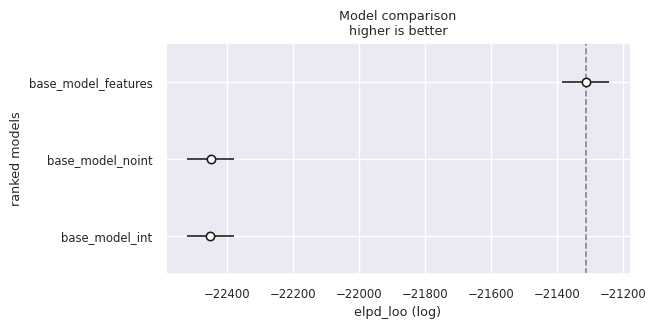

In [28]:
# plotting the comparisons
az.plot_compare(model_compare)

array([[<Axes: title={'center': 'beta_0'}>,
        <Axes: title={'center': 'beta_0'}>],
       [<Axes: title={'center': 'beta_extracurricular'}>,
        <Axes: title={'center': 'beta_extracurricular'}>],
       [<Axes: title={'center': 'beta_hours'}>,
        <Axes: title={'center': 'beta_hours'}>],
       [<Axes: title={'center': 'beta_practice'}>,
        <Axes: title={'center': 'beta_practice'}>],
       [<Axes: title={'center': 'beta_previous'}>,
        <Axes: title={'center': 'beta_previous'}>],
       [<Axes: title={'center': 'beta_sleep'}>,
        <Axes: title={'center': 'beta_sleep'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

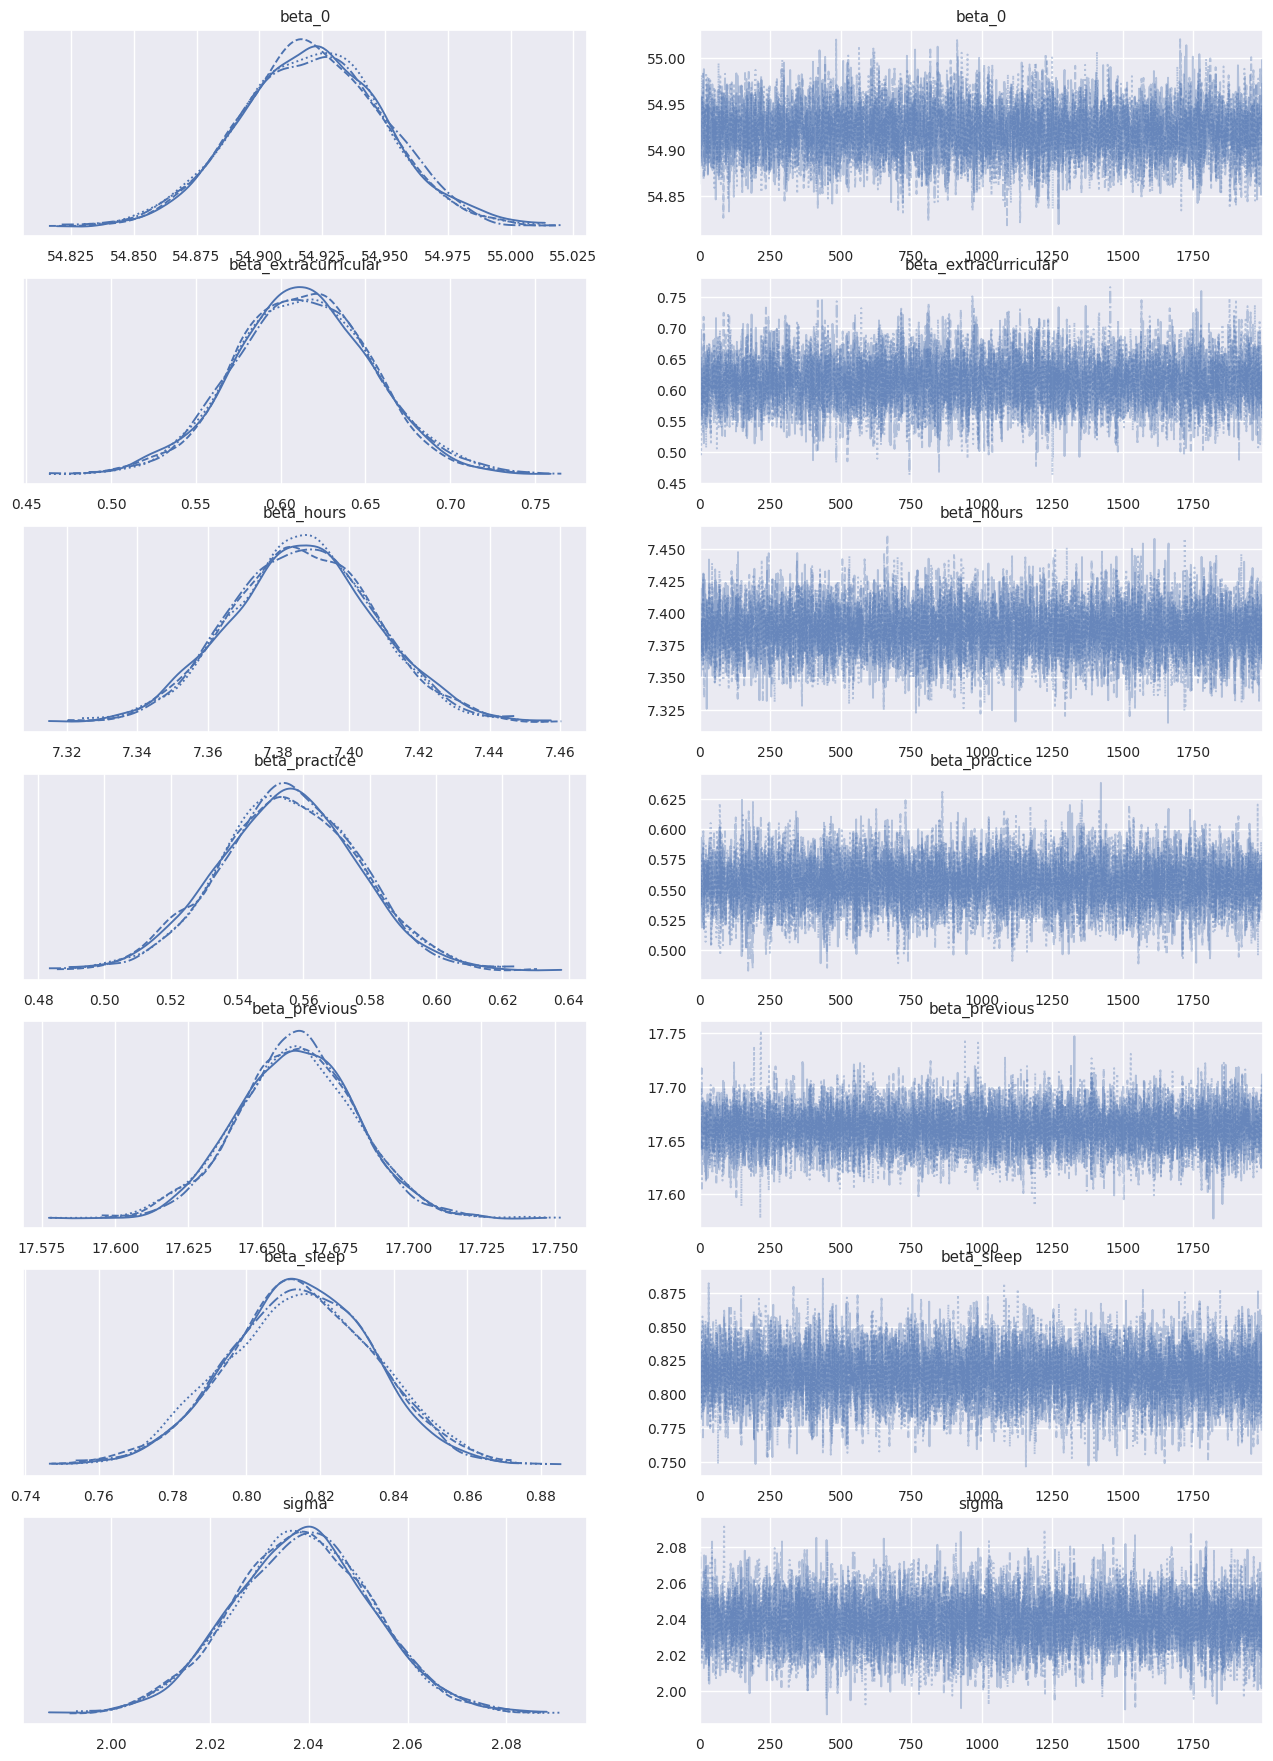

In [36]:
# inspecting model trace
az.plot_trace(idata_features,figsize=(16,22))

<Axes: xlabel='y'>

/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


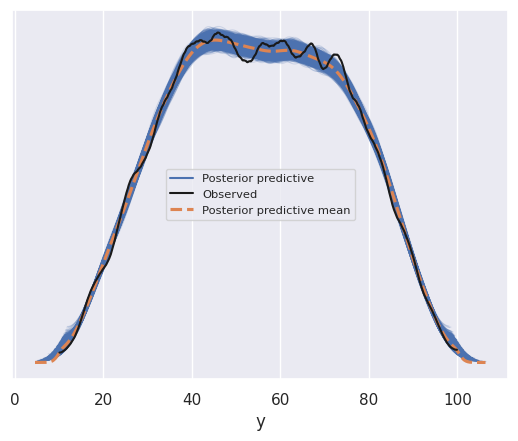

In [37]:
# inspecting posterior predictive checks
az.plot_ppc(idata_features)

array([[<Axes: title={'center': 'beta_0'}, xlabel='Quantile', ylabel='ESS for small intervals'>,
        <Axes: title={'center': 'beta_extracurricular'}, xlabel='Quantile', ylabel='ESS for small intervals'>,
        <Axes: title={'center': 'beta_hours'}, xlabel='Quantile', ylabel='ESS for small intervals'>],
       [<Axes: title={'center': 'beta_practice'}, xlabel='Quantile', ylabel='ESS for small intervals'>,
        <Axes: title={'center': 'beta_previous'}, xlabel='Quantile', ylabel='ESS for small intervals'>,
        <Axes: title={'center': 'beta_sleep'}, xlabel='Quantile', ylabel='ESS for small intervals'>],
       [<Axes: title={'center': 'sigma'}, xlabel='Quantile', ylabel='ESS for small intervals'>,
        <Axes: >, <Axes: >]], dtype=object)

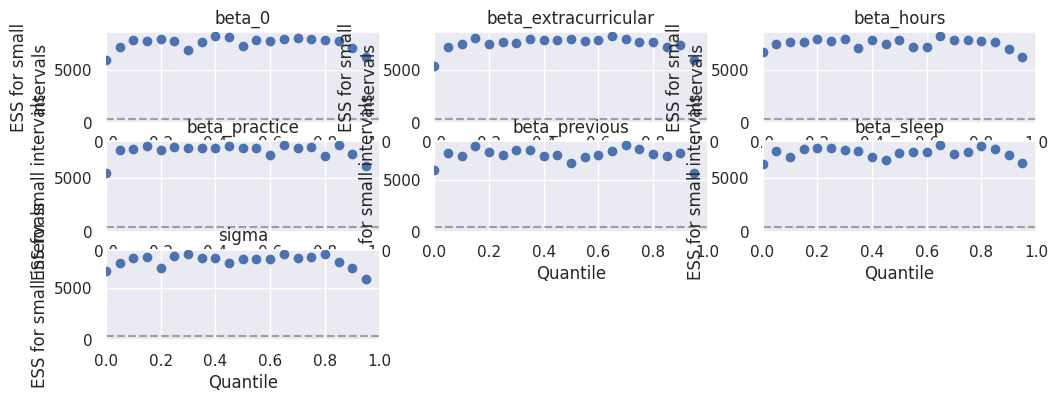

In [38]:
# inspecting ess for quantiles
az.plot_ess(idata_features, figsize=(12,4))

array([[<Axes: title={'center': 'beta_0'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'beta_extracurricular'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'beta_hours'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'beta_practice'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'beta_previous'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'beta_sleep'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'sigma'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: >, <Axes: >]], dtype=object)

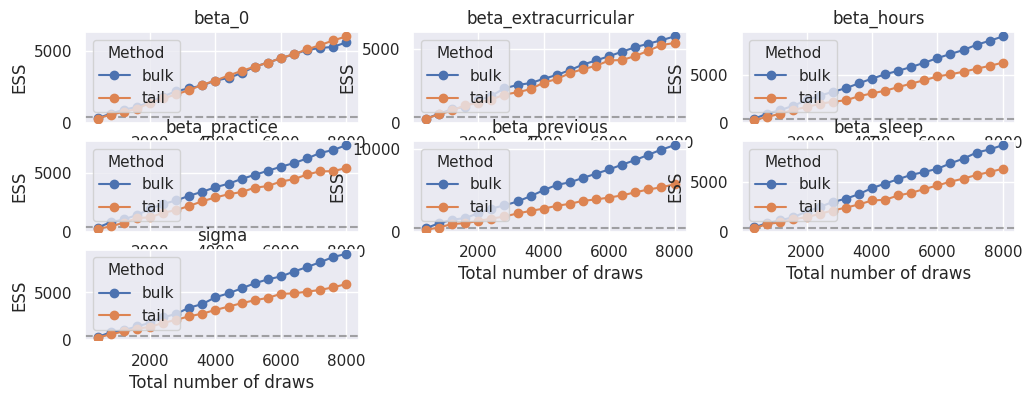

In [39]:
# inspecting ess evolution
az.plot_ess(idata_features, kind="evolution", figsize=(12,4))

<Axes: >

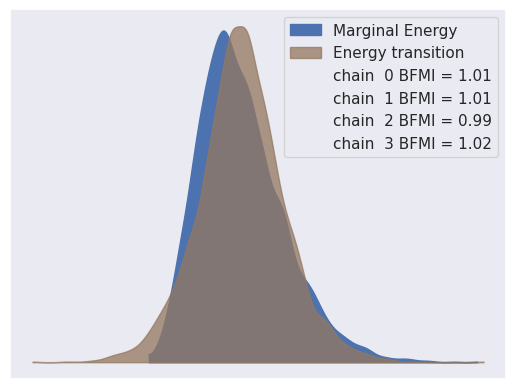

In [40]:
# inspecting energy plot
az.plot_energy(idata_features)

array([[<Axes: title={'center': 'beta_0'}>,
        <Axes: title={'center': 'beta_extracurricular'}>,
        <Axes: title={'center': 'beta_hours'}>],
       [<Axes: title={'center': 'beta_practice'}>,
        <Axes: title={'center': 'beta_previous'}>,
        <Axes: title={'center': 'beta_sleep'}>],
       [<Axes: title={'center': 'sigma'}>, <Axes: >, <Axes: >]],
      dtype=object)

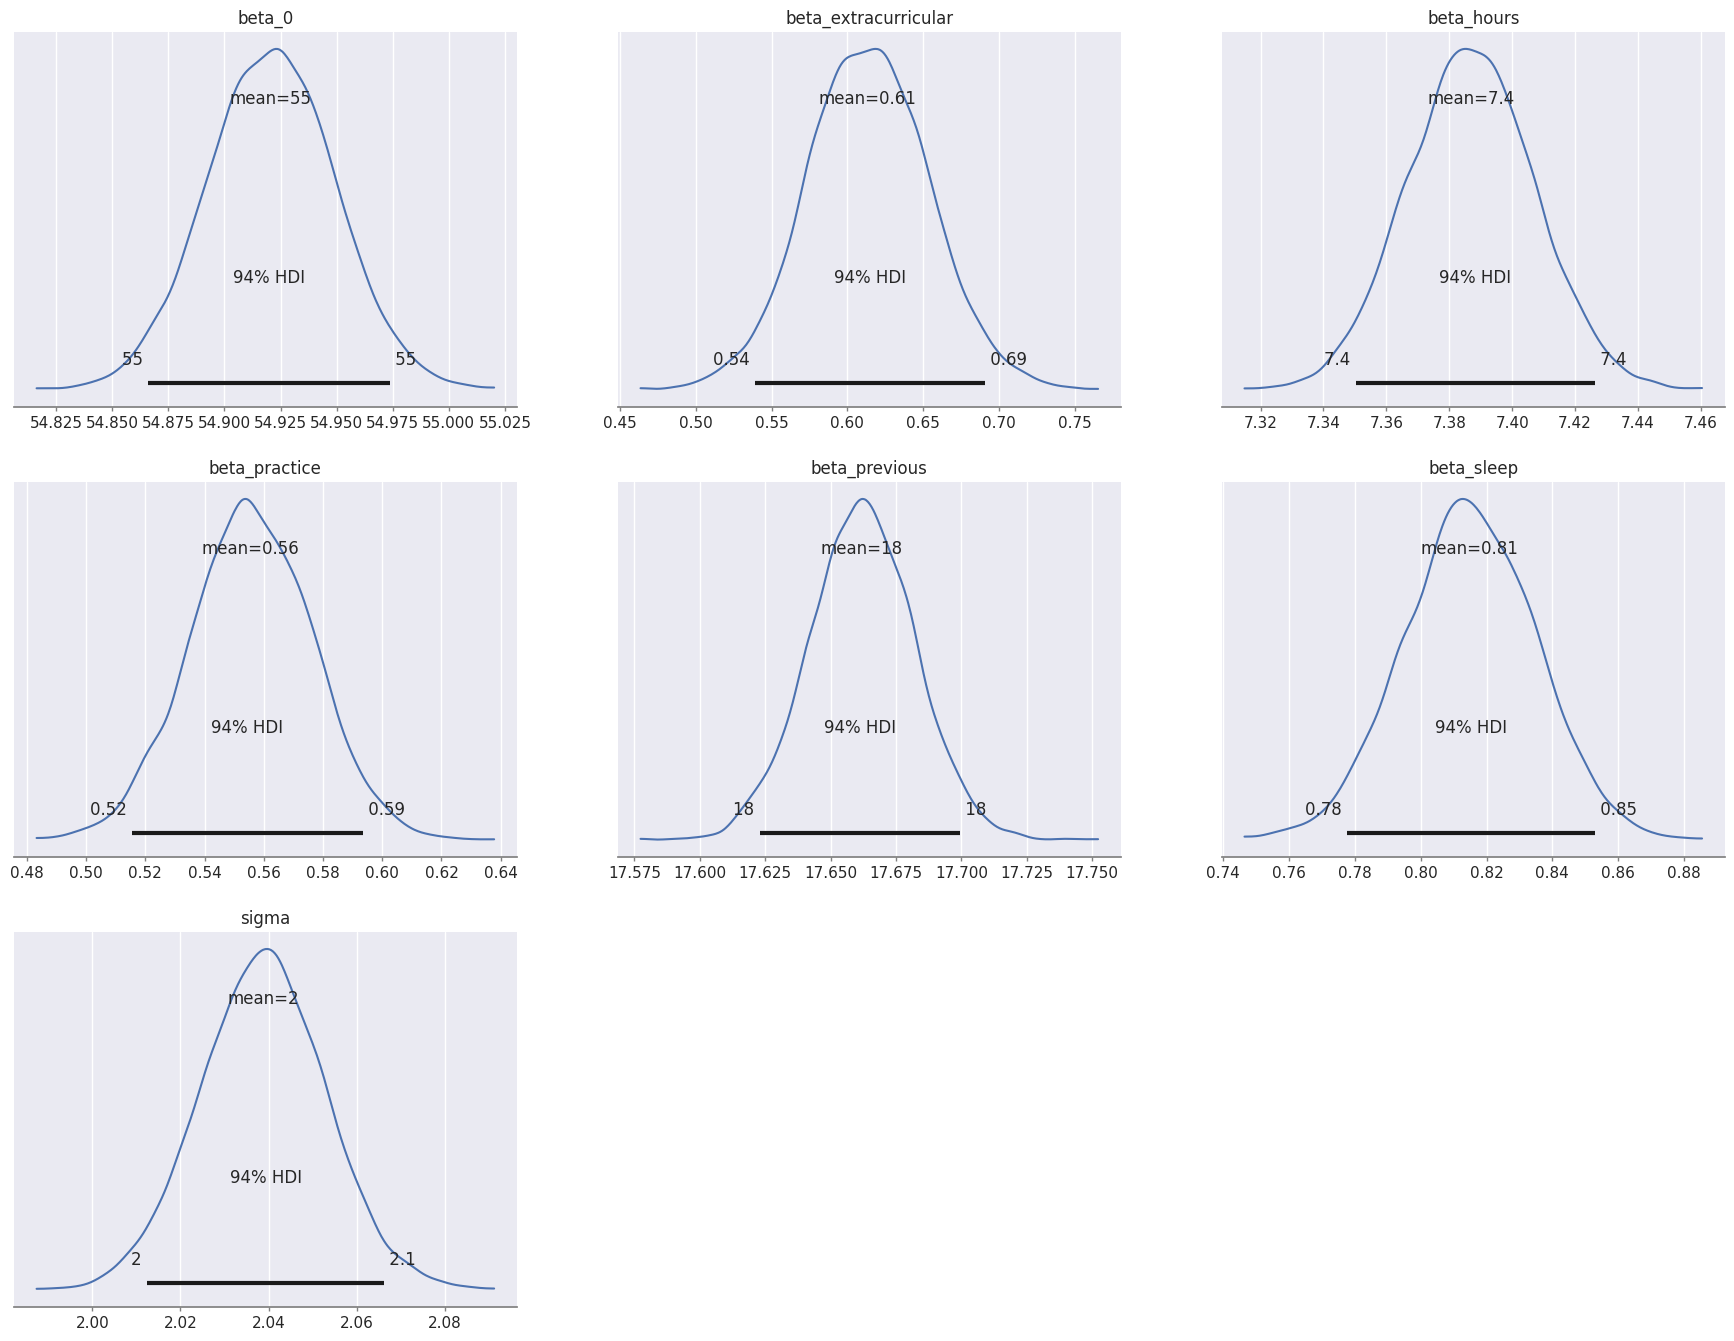

In [43]:
# inspecting posterior observations
az.plot_posterior(idata_features)

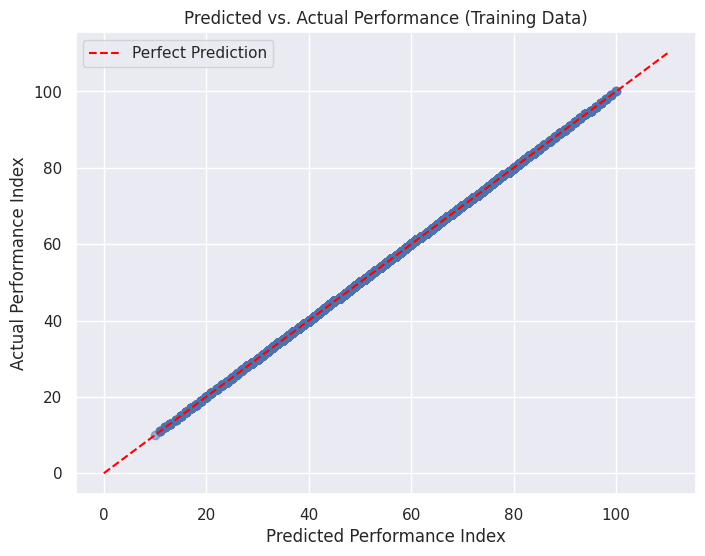

In [46]:
# Grab predictions from your original idata
y_preds = idata_features.posterior_predictive["y"].stack(samples=("chain", "draw")).values

# Take the mean prediction for each row
mean_preds = y_preds.mean(axis=0)
actual_y = idata_features.observed_data["y"].values

# Plot predicted vs. actual
plt.figure(figsize=(8, 6))
plt.scatter(actual_y, df["Performance Index"].values, alpha=0.5)
plt.plot([0, 110], [0, 110], linestyle="--", color="red", label="Perfect Prediction")
plt.xlabel("Predicted Performance Index")
plt.ylabel("Actual Performance Index")
plt.title("Predicted vs. Actual Performance (Training Data)")
plt.legend()
plt.grid(True)
plt.show()
